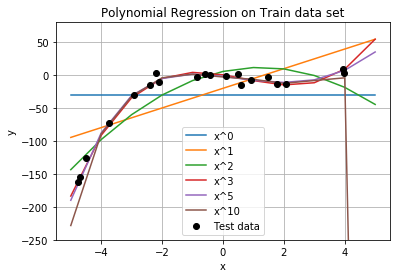

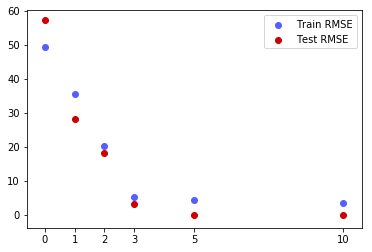

In [49]:
import numpy as np
from matplotlib import pyplot as plt

#Read coordinate csv. Col 1 is x coords and Col2 is y coords.
def read_coords(filename):    
    myFile = open(filename)
    row =0
    coords =[]
    for line in myFile:
        coords.append(line.rstrip().split(",")[:])
        #coords[row] = line.rstrip().split(",")[:]
    myFile.close()
    return coords
#Find the sum of x to a certain power. This is used to construct the terms of the left hand side of the system
def findSum(coords,power):
    sumOfCoords = 0
    for point in coords:
        sumOfCoords += point**power
    return sumOfCoords
#Find the sum of x*y where x is raised to a power. This is used to determine terms on the RHS of system
def findEndTerm(coords, y_train, power):
    sumOfCoords = 0
    index = 0
    for point in coords:
        sumOfCoords += (point**power)*y_train[index]
        index += 1
    return sumOfCoords

'''
System looks as follows:
(sum[x^0])*a0 + (sum[x^1])*a1 + ... + (sum[x^n])*an = sum[x^m * y]
(sum[x^1])*a0 + (sum[x^2])*a1 + ... + (sum[x^n])*an = sum[x^m * y]
(sum[x^2])*a0 + (sum[x^3])*a1 + ... + (sum[x^n])*an = sum[x^m * y]

Notice that the first term in each row, is always to the power of the zero-indexed row number, so
in row 1 ( row 0 ) we start with 0, and pattern remains, so we will start iteraing from `rowNumber`
Then it goes up to rowNumber + dimension, so if our data is a 3x3 square matrix, dimension is 3 so on each line
we iterate up to rowNumber + 3.
The power term is then always raised to the same power as the first term, so the index of the current row. 

Using these rules we can form our system:
'''
def formSystem(coords, y_train, dim):
    #Define system arr
    system = []
    
    for row in range(dim):
        #Define current row, that will contain column data as its entries
        temp = []
        #We iterate up to row number + dimension on each row, +1 for inclusivity
        for col in range(row, row+dim+1):
            #If this isnt the last row then find the sum term
            if(col != row+dim):
                sumToPow = findSum(coords, col)
                temp.append(sumToPow)
            #If got to last term, calculate that
            else:
                lastTerm = findEndTerm(coords, y_train, row)
                temp.append(lastTerm)
        #Add row
        system.append(temp)
    return system

#Wrapper for regression
def pol_regression(features_train, y_train, degree):
    system = formSystem(features_train, y_train, degree+1)
    
    #Convert to np array
    system = np.asarray(system)
    #.shape[1] is how many columns are in each row
    cols = system.shape[1]
    #keep all but the last row (RHS)
    a = system[:,0:cols-1]
    #Right hand side is then 
    b = system[:,cols-1]
    solution = np.linalg.solve(a, b)
    return system, solution

#Generate polynomial dynamically from coefficients and set of x ([-5, 5])
def genPoly(x, coeffs):
    o = len(coeffs)
    y = 0
    for i in range(o):
        y += coeffs[i]*x**i
    return y
#Plot polynomials and data set
def plot_polynomials(solutions, train_x, train_y):
    #Interval [-5, 5]
    x = np.arange(-5, 6)
    #Plot current polynomial and label appropriately for legend detection
    plt.plot(x, genPoly(x, solutions), label="x^"+str(len(solutions)-1))
    plt.title("Polynomial Regression on Train data set")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    return plt
#Add training points and display
def finish_plot(plot, train_x, train_y):
    #Set these points to appear on foreground
    plot.scatter(train_x, train_y, label="Test data", zorder=5, c="#000000")
    plot.legend()
    #Need to limit the axes otherwise the x^10 polynomial goes down to ~-2000 on the y axis
    #rendering everything else unreadable
    plot.gca().set_ylim([-250, 80])
    plot.show()

#Wrapper function for calculating RMSE values for ALL requested polynomials
def eval_polys(data):
    #Data needs to be 2d so that we can shuffle while retaining x,y pairs
    #Shuffle data for randomness
    np.random.shuffle(data)
    elems = len(data)
    #Define set proportions we want
    train_prop = 0.7
    test_prop = 1 - train_prop
    
    #Slice data array into two seperate arrays depending on proportions
    train_data = data[0:int(elems*train_prop)]
    test_data = data[int(elems*train_prop):]
    
    #Then generate each polynomial again on just the train set
    #We will store RMSE's in a 2D array, where each sub-array will have 
    #[0] as the train RMSE
    #[1] as the test RMSE
    rmses = []
    for i in range(11):
        if i in [0, 1, 2, 3, 5, 10]:
            #RMSE
            temp = []
            train_rmse = eval_pol_regression(train_data[:,0], train_data[:,1], i)
            test_rmse = eval_pol_regression(test_data[:,0], test_data[:,1], i)
            #Store
            temp.append(train_rmse)
            temp.append(test_rmse)
            rmses.append(temp)
    return rmses

#Calculates RMSE between params (predicted y) and y
def calc_rmse(params, x, y):
    rmse = 0
    index = 0
    size = len(y)
    for point in params:
        difference = (point - y[index])**2/size
        rmse = rmse + difference
        index = index + 1
    rmse = np.sqrt(rmse)
    return rmse

#Generates polynomial on data and calculates RMSE
def eval_pol_regression(x, y, degree):
    #Get solution of system based on training data
    system,solution = pol_regression(x, y, degree)
    #Generate predicted values
    yhat = genPoly(x, solution)
    #Generate RMSE 
    rmse = calc_rmse(yhat, x, y)
    return rmse

def plotRMSE(rmses):
    x = [0, 1, 2, 3, 5, 10]
    plt.xticks(x)
    for i in range(len(x)):
        plt.scatter(x[i], rmses[i][0], c="#555FFF")
        plt.scatter(x[i], rmses[i][1], c="#CC0000")
    plt.legend(["Train RMSE", "Test RMSE"])
    plt.show()

#Read in data, convert to numpy array and to float array
data = read_coords("ML_task1.csv")
data = np.asarray(data)
data = data.astype(float)
#system,solution = pol_regression(data[:,0], data[:,1], 2)
#plot_polynomials(solution, data[:,0], data[:,1])

#Contains matplotlib.pylot.plot, init to retain in the scope
currPlot = 0
#Generate graph by iterating from 0 to 11 
for i in range(11):
    #Degrees that we want to generate
    if i in [0, 1, 2, 3, 5, 10]:
        #Get polynomial
        system,solution = pol_regression(data[:,0], data[:,1], i)
        #Plot and return current state of plot
        currPlot = plot_polynomials(solution, data[:,0], data[:,1])
    else:
        continue
#When we got everything, show
finish_plot(currPlot, data[:,0], data[:,1] )

rmses = eval_polys(data)
plotRMSE(rmses)